## Some experiments to check data distributions and model performance

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer, LightningModule
from torch.utils.data import random_split
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

import pandas as pd

from model import GRUD
from data import TimeSeriesDataset

from datetime import datetime
import argparse

In [2]:
seed = 42
seq_len = 100
step_size = 10

def split_data(
    df,
    start_test="2023-06-14 07:36:33.297403",
    end_test="2023-06-14 08:03:30.700492",
):
    """The timestamps are in column 'Time (s)"""
    # Definne the test set as the rows in between the start_test and end_test timestamps
    test_df = df[(df["Time (s)"] >= start_test) & (df["Time (s)"] <= end_test)]
    # Define the train set as the rows before the start_test timestamp and after the end_test timestamp
    train_df = df[(df["Time (s)"] < start_test) | (df["Time (s)"] > end_test)]
    return train_df, test_df

df = pd.read_csv('data.csv')

# Split the dataframe into train, validation, and test
train_df, test_df = split_data(df)
# create the training dataset
train_dataset = TimeSeriesDataset(
    train_df
)

# create the test dataset using the scaler from the training dataset
test_dataset = TimeSeriesDataset(
    test_df,
    scaler=train_dataset.get_scaler(),
    label_encoder=train_dataset.get_label_encoder(),
)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def metrics(labels, predictions, model_name):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    
    cm = confusion_matrix(labels, predictions)
    class_labels = test_dataset.get_label_encoder().classes_

    # Map the class labels break-btn: Break, overhanging-btn: Overhanging, straight-btn: Straight, slab-btn: Slab, falling-btn: Falling, lowering-btn: Lowering
    for i, label in enumerate(class_labels):
        if label == 'break-btn':
            class_labels[i] = 'Break'
        elif label == 'overhanging-btn':
            class_labels[i] = 'Overhanging'
        elif label == 'straight-btn':
            class_labels[i] = 'Straight'
        elif label == 'slab-btn':
            class_labels[i] = 'Slab'
        elif label == 'falling-btn':
            class_labels[i] = 'Falling'
        elif label == 'lowering-btn':
            class_labels[i] = 'Lowering'
    
    sns.set_style("whitegrid")
    sns.set_context("paper")
    plt.figure(figsize=(6, 6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, 
                annot=True, 
                cmap="Blues", 
                fmt="d", 
                xticklabels=class_labels, 
                yticklabels=class_labels, 
                cbar=False
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.savefig("confusion_matrix_{}.pdf".format(model_name), bbox_inches='tight')
    plt.show()
    
    return accuracy, precision, recall, f1

models_paths = [
    'models/baseline_model.pt',
    'models/finetuned_apc_model.pt',
    'models/finetuned_coarse_model.pt'
]

Loading model: Baseline
Accuracy: 0.7093963907902925
Precision: 0.6263017564431389
Recall: 0.7093963907902925
F1-Score: 0.6436046838907001


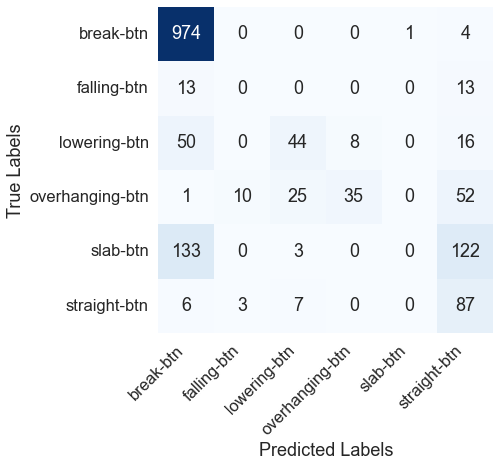

Loading model: Finetuned APC


c:\Users\lverm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6092097075295582
Precision: 0.37113646774824977
Recall: 0.6092097075295582
F1-Score: 0.4612655094133314


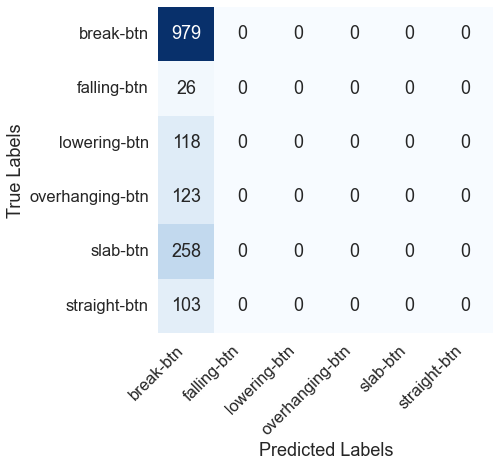

Loading model: Finetuned Coarse


c:\Users\lverm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6801493466085874
Precision: 0.7300094655439189
Recall: 0.6801493466085874
F1-Score: 0.6345684221592044


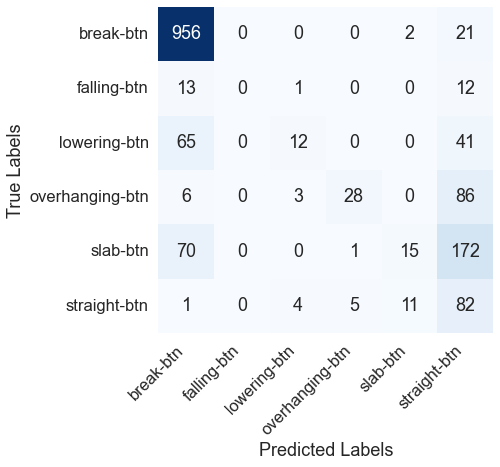

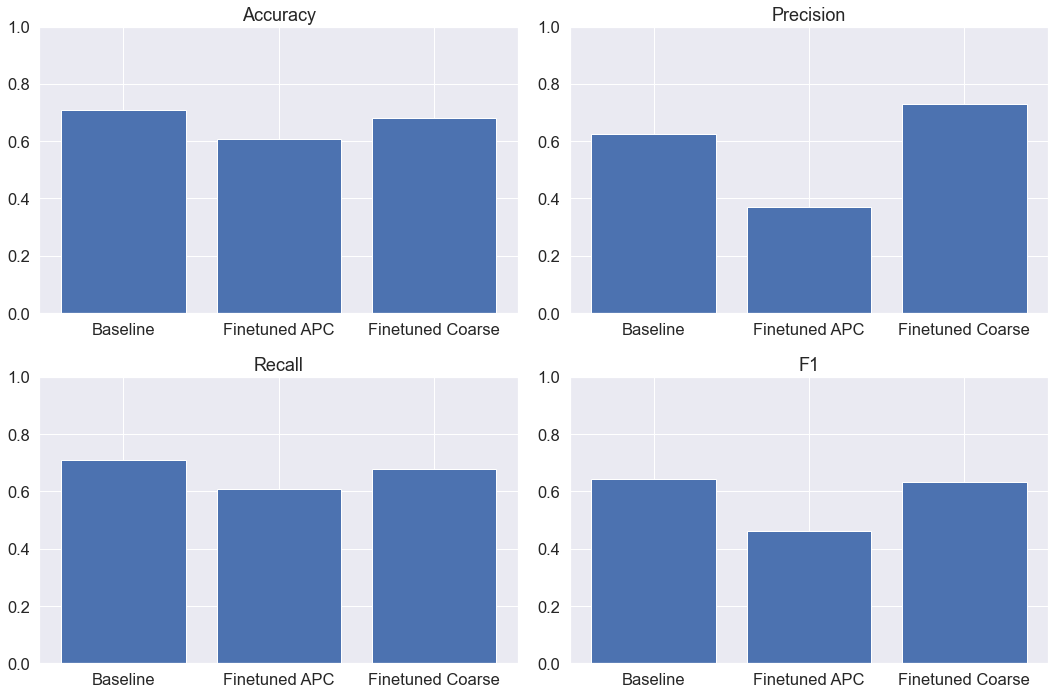

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

models_paths = [
    'models/baseline_model.pt',
    'models/finetuned_apc_model.pt',
    'models/finetuned_coarse_model.pt'
]

model_names = ["Baseline", "Finetuned APC", "Finetuned Coarse"]

# Prepare the test DataLoader
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=10,
)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# To store the metrics for all models
model_metrics = {}

for model_path, model_name in zip(models_paths, model_names):
    # Load the model
    print("Loading model:", model_name)
    checkpoint = torch.load(model_path)
    model = GRUD(input_size=17, hidden_size=17, output_size=6)
    model.load_state_dict(checkpoint)
    model = model.to(device)

    # Make predictions on the test set
    model.eval()

    # To store the predictions and true labels
    all_preds = []
    all_labels = []

    # Predict on test set
    with torch.no_grad():
        for (x, x_mean, mask, delta, labels) in test_dataloader:
            # Move tensors to device
            x, x_mean, mask, delta, labels = x.to(device), x_mean.to(device), mask.to(device), delta.to(device), labels.to(device)
            # Forward pass
            outputs = model(x, x_mean, mask, delta)
            # Get the index of the class with maximum probability
            _, preds = torch.max(outputs, dim=1)
            # Store the predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy, precision, recall, f1 = metrics(all_labels, all_preds, model_name)
    model_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    axs[i].bar(model_metrics.keys(), [metrics[metric] for metrics in model_metrics.values()])
    axs[i].set_title(metric)
    axs[i].set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# Convert the dictionary to a DataFrame
df = pd.DataFrame(model_metrics).T

# Print the DataFrame as a LaTeX table
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  Accuracy &  Precision &  Recall &   F1 \\
\midrule
Baseline         &      0.71 &       0.63 &    0.71 & 0.64 \\
Finetuned APC    &      0.61 &       0.37 &    0.61 & 0.46 \\
Finetuned Coarse &      0.68 &       0.73 &    0.68 & 0.63 \\
\bottomrule
\end{tabular}



C:\Users\lverm\AppData\Local\Temp\ipykernel_9116\1705630832.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="%.2f"))


In [ ]:
# Print the shapes of the datasets
print(f"Training set shape: {train_dataset.x.shape}")
# print(f"Validation set shape: {val_dataset.x.shape}")
print(f"Test set shape: {test_dataset.x.shape}")

# # Print the first few labels in each dataset
# print("First few labels:")
# print("Training set:", train_dataset.y[:50].numpy())
# # print("Validation set:", val_dataset.y[:10].numpy())
# print("Test set:", test_dataset.y[:10].numpy())


# Print the distributions of the labels in each dataset
print("Label distributions:")
print("Training set:", np.bincount(train_dataset.y.numpy()))
# print("Validation set:", np.bincount(val_dataset.y.numpy()))
print("Test set:", np.bincount(test_dataset.y.numpy()))

# Print the datasets as sets
print("Training set:", set(train_dataset.y.numpy()))
# print("Validation set:", set(val_dataset.y.numpy()))
print("Test set:", set(test_dataset.y.numpy()))


Training set shape: torch.Size([3215, 100, 17])
Test set shape: torch.Size([1607, 100, 17])
Label distributions:
Training set: [2294    7  100   84  193  537]
Test set: [979  26 118 123 258 103]
Training set: {0, 1, 2, 3, 4, 5}
Test set: {0, 1, 2, 3, 4, 5}


NameError: name 'val_dataset' is not defined

In [ ]:


# Analyze the datasets
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate label distribution
train_label_distribution = np.bincount(train_dataset.y.flatten()) / len(train_dataset.y.flatten())
val_label_distribution = np.bincount(val_dataset.y.flatten()) / len(val_dataset.y.flatten())
test_label_distribution = np.bincount(test_dataset.y.flatten()) / len(test_dataset.y.flatten())

# Plot label distribution
plt.figure(figsize=(12, 6))
plt.bar(np.arange(6), train_label_distribution, alpha=0.5, label='Train')
plt.bar(np.arange(6), val_label_distribution, alpha=0.5, label='Validation')
plt.bar(np.arange(6), test_label_distribution, alpha=0.5, label='Test')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.legend()
plt.show()


# Calculate missing values
missing_values_train = np.sum(~train_dataset.mask.numpy().astype(bool)) / np.prod(train_dataset.mask.shape)
missing_values_val = np.sum(~val_dataset.mask.numpy().astype(bool)) / np.prod(val_dataset.mask.shape)
missing_values_test = np.sum(~test_dataset.mask.numpy().astype(bool)) / np.prod(test_dataset.mask.shape)

print(f"Missing values in training data: {missing_values_train*100:.2f}%")
print(f"Missing values in validation data: {missing_values_val*100:.2f}%")
print(f"Missing values in testing data: {missing_values_test*100:.2f}%")

# Plot feature distribution
plt.figure(figsize=(12, 6))
for i in range(train_dataset.x.shape[2]):
    sns.histplot(train_dataset.x[:, :, i].numpy().flatten(), bins=50, kde=True)
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title('Feature Distribution in Training Data')
plt.show()

